# Single Commodity Flow Optimization

**References:** 
1. N. Moehle, E. Busseti, S. Boyd, and M. Wytock. [*Dynamic Energy Management*](https://stanford.edu/~boyd/papers/dyn_ener_man.html) in Large Scale Optimization in Supply Chains and Smart Manufacturing, Springer, pp. 69-126, 2019.
2. P. Yin, S. Diamond, B. Lin, and S. Boyd. [*Network Optimization for Unified Packet and Circuit Switched Networks.*](https://stanford.edu/~boyd/papers/net_opt.html) Optimization and Engineering, 21(1):159-180, 2020.

## Introduction

Consider a network with $p$ nodes and $q$ (directed) arcs described by an incidence matrix $B \in \mathbf{R}^{p \times q}$ with

$$B_{ij} = \begin{cases}
1 & \text{arc $j$ enters node $i$} \\
-1 & \text{arc $j$ leaves node $i$} \\
0 & \text{otherwise}.\end{cases}$$

Suppose a single commodity flows in this network. Let $z \in \mathbf{R}^q$ denote the arc flows and $s \in \mathbf{R}^p$ the node sources. We have the flow conservation constraint $Bz + s = 0$, which in turn implies that $\mathbf{1}^Ts = 0$ since $B^T\mathbf{1} = 0$. The total cost of traffic on the network is the sum of a flow cost, represented by $\psi:\mathbf{R}^q \rightarrow \mathbf{R} \cup \{\infty\}$, and a source cost, represented by $\phi:\mathbf{R}^p \rightarrow \mathbf{R} \cup \{\infty\}$. We assume that these costs are separable with respect to the flows and sources, \ie, $\psi(z) = \sum_{j=1}^q \psi_j(z_j)$ and $\phi(s) = \sum_{i=1}^p \phi_i(s_i)$. Our goal is to choose flow and source vectors such that the network cost is minimized:

$$\begin{array}{ll}
\mbox{minimize} & \psi(z) + \phi(s) \\
\mbox{subject to} & Bz + s = 0
\end{array}$$

with respect to $z$ and $s$.

## DC Power Flow Problem

We consider a special case modeled on the DC power flow problem in power engineering. The flow costs are quadratic with a capacity constraint:

$$\psi_j(z_j) = \begin{cases}
c_jz_j^2 & |z_j| \leq z_j^{\max} \\
\infty & \text{otherwise.}
\end{cases}$$

The source costs are determined by the node type, which can fall into one of three categories:

1. **Transfer/way-point nodes** fixed at $s_i = 0$, i.e., 
$$\phi_i(s_i) = d_is_i^2 + I_{\{0\}}(s_i) = I_{\{0\}}(s_i).$$
2. **Sink nodes** fixed at $s_i = L_i$ (for $L_i < 0$), i.e., 
$$\phi_i(s_i) = d_is_i^2 + I_{\{L_i\}}(s_i) = d_iL_i^2 + I_{\{L_i\}}(s_i).$$
3. **Source nodes** with cost
$$\phi_i(s_i) = \begin{cases}
d_is_i^2 & 0 \leq s_i \leq s_i^{\max} \\
\infty & \text{otherwise}.
\end{cases}$$

The vectors $c \in \mathbf{R}_+^q, d \in \mathbf{R}_+^p, z^{\max} \in \mathbf{R}^q$, and $s^{\max} \in \mathbf{R}^p$ are constants. Here we have used the set indicator function $I_C$, which for any set $C$ is defined as

$$I_C(x) = \begin{cases}
0 & x \in C \\
\infty & \text{otherwise.}
\end{cases}$$

## Reformulate Problem

The DC power flow problem can be restated in standard form by letting $x_1 \in \mathbf{R}^2, x_2 \in \mathbf{R}^p$,

$$f_1(x_1) = \psi(x_1), \quad f_2(x_2) = \phi(x_2),$$
$$A_1 = B, \quad A_2 = I, \quad b = 0.$$

Since costs are separable, the proximal operators can be calculated elementwise with

$$(\mathbf{prox}_{tf_1}(v))_j = \Pi_{[-z_j^{\max},z_j^{\max}]}
\left(\frac{v_j}{2 tc_j + 1}\right), \quad j = 1,\ldots,q,$$
$$(\mathbf{prox}_{tf_2})(w))_i = \Pi_{[0,s_i^{\max}]}
\left(\frac{w_i}{2 td_i + 1}\right), \quad i 
\text{ is a source node,}$$

where $\Pi_C$ denotes the projection onto a set $C$.

## Generate Data

We solve an instance with $p = 15$ and $q = 20$. See Section 7.4 of [A. Fu, J. Zhang, and S. Boyd (2019)](https://stanford.edu/~boyd/papers/a2dr.html) for a detailed description of the data generation process.

In [1]:
import numpy as np
import scipy.sparse.linalg as spLA
from scipy import sparse
from itertools import combinations

np.random.seed(1)

# Problem data.
p = 15   # Number of sources.
q = 20   # Number of flows.

# Select source pairs without replacement.
pairs = list(combinations(range(p),2))
p_sel = np.random.choice(range(len(pairs)), size=q-p+1, replace=False)

# Construct a random incidence/adjacency matrix.
B = sparse.lil_matrix((p,q))
G_adj = np.zeros((p,p))
for i in range(q-p+1):
    idxs = pairs[p_sel[i]]
    tmp = np.random.rand()
    if tmp > 0.5:
        B[idxs[0],i] = 1
        B[idxs[1],i] = -1
        G_adj[idxs[1],idxs[0]] = 1
    else:
        B[idxs[0],i] = -1
        B[idxs[1],i] = 1
        G_adj[idxs[0],idxs[1]] = 1 
for j in range(q-p+1,q):
    B[j-(q-p+1),j] = 1
    B[j-(q-p),j] = -1
    G_adj[j-(q-p),j-(q-p+1)] = 1
B = sparse.csr_matrix(B)

# Generate source and flow range data
s_tilde = np.random.randn(p)
p1, p2, p3 = int(p/3), int(p/3*2), int(p/6*5)
s_tilde[:p1] = 0
s_tilde[p1:p2] = -np.abs(s_tilde[p1:p2])
s_tilde[p2:] = np.sum(np.abs(s_tilde[p1:p2])) / (p-p2)
L = s_tilde[p1:p2]
s_max = np.hstack([s_tilde[p2:p3] + 0.001, (s_tilde[p3:] + 0.001)*2])

res = spLA.lsqr(B, -s_tilde, atol=1e-16, btol=1e-16)
z_tilde = res[0]
q1 = int(q/2)
z_max = np.abs(z_tilde) + 0.001
z_max[q1:] = 2*z_max[q1:]

# Generate cost coefficients
c = np.random.rand(q)
d = np.random.rand(p)

## Solve Problem

In [2]:
from a2dr import a2dr
from a2dr.proximal import *

# Convert problem to standard form.
zeros = np.zeros(p1)
def prox_sat(v, t, c, v_lo = -np.inf, v_hi = np.inf):
    return prox_box_constr(prox_sum_squares(v, t*c), t, v_lo, v_hi)
prox_list = [lambda v, t: prox_sat(v, t, c, -z_max, z_max),
             lambda v, t: np.hstack([zeros, L, prox_sat(v[p2:], t, d[p2:], 0, s_max)])]
A_list = [B, sparse.eye(p)]
b = np.zeros(p)

# Solve with A2DR.
a2dr_result = a2dr(prox_list, A_list, b)
a2dr_z = a2dr_result['x_vals'][0]
a2dr_s = a2dr_result['x_vals'][1]

# Compute objective and constraint violations.
a2dr_obj = np.sum(c*a2dr_z**2) + np.sum(d*a2dr_s**2)
a2dr_constr_vio = [np.maximum(np.abs(a2dr_z) - z_max, 0), 
                    a2dr_s[:p1], 
                    np.abs(a2dr_s[p1:p2] - L), 
                    np.maximum(-a2dr_s[p2:], 0),
                    np.maximum(a2dr_s[p2:] - s_max,0),
                    B.dot(a2dr_z) + a2dr_s]
a2dr_constr_vio_norm = np.linalg.norm(np.hstack(a2dr_constr_vio))

# Print solution.
print("Objective value:", a2dr_obj)
print("Constraint violation:", a2dr_constr_vio_norm)

----------------------------------------------------------------
a2dr v0.1 - Prox-Affine Distributed Convex Optimization Solver
                 (c) Anqi Fu, Junzi Zhang
                 Stanford University, 2019
----------------------------------------------------------------
### Preconditioning starts ... ###
### Preconditioning finished.  ###
max_iter = 3000, t_init (after preconditioning) = 0.49, eps_abs = 1e-06, eps_rel = 1e-08
precond = True, ada_reg = True, anderson = True, m_accel = 10, lam_accel = 1e-08
aa_method = lstsq, D_safe = 1000000.00, eps_safe = 1e-06, M_safe = 30
variables n = 35, constraints m = 15
nnz(A) = 55
Setup time: 1.55e-02
----------------------------------------------------
 iter | total res | primal res | dual res | time (s)
----------------------------------------------------
     0| 3.99e+00    9.04e-01     3.89e+00   7.73e-02
   100| 3.66e-04    3.66e-04     7.98e-07   5.89e-01
   200| 3.66e-04    3.66e-04     2.41e-09   1.16e+00
   300| 3.66e-04    3.66

## Visualize Network

Nodes of graph: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Edges of graph: 
[(1, 0), (2, 1), (3, 2), (3, 4), (3, 7), (4, 3), (5, 4), (5, 11), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 2), (11, 10), (12, 11), (13, 9), (13, 12), (14, 2), (14, 13)]


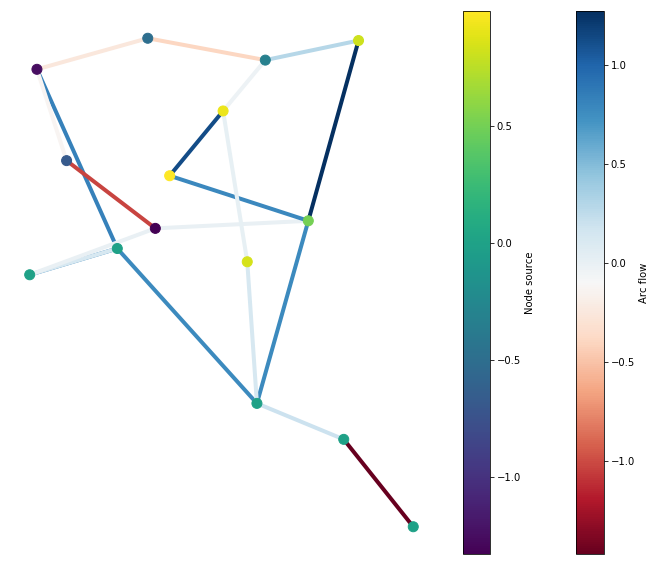

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

np.random.seed(1028) # fix the spring layout randomness

# Form graph from adjacency matrix.
G = nx.from_numpy_matrix(G_adj, create_using=nx.DiGraph)

print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

# Plot network.
plt.figure(figsize=(12,10))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_color=a2dr_s, with_labels=False, node_size=100, node_cmap=plt.cm.Reds)
edges = nx.draw_networkx_edges(G, pos, edge_color=a2dr_z, width=4, edge_cmap=plt.cm.RdBu, arrows=False)

edge_norm = plt.cm.colors.Normalize(np.min(a2dr_z), np.max(a2dr_z))
edge_cbar = plt.cm.ScalarMappable(norm=edge_norm, cmap=plt.cm.RdBu)
edge_cbar.set_array(a2dr_z)
plt.colorbar(edge_cbar, label="Arc flow")
plt.colorbar(nodes, label="Node source")
plt.axis("off")
plt.show()